In [2]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import cv2
import pandas as pd
from skimage import io
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches

c:\Users\Asus\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Dataset 

In [3]:

class SolarRadiance(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image = cv2.imread(img_path)#, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (6, 8))

        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print( "Label",y_label)
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Data

In [5]:

# Hyperparameters
in_channel = 1
batch_size = 100
num_epochs = 5
cr = 1 # if cr = 0 the model will be trained with RMSE loss and vice versa
lr=0.001 # learning rate

In [6]:
images = 'infrared/'
labels = 'filtered_pyranometer.csv'

# images = 'mini_ds/'
# labels = 'mini_ds.csv'

# Load Data
dataset = SolarRadiance(
    csv_file= labels,
    root_dir= images,
    transform=transforms.ToTensor(),
)

# Dataset is actually a lot larger ~25k images, just took out 10 pictures
# to upload to Github. It's enough to understand the structure and scale
# if you got more images.
datasetLength = len(dataset)
print(datasetLength)
train_size = int(0.8 * datasetLength)
val_size = datasetLength - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)


46527


Model

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained MobileNet model without its final classification layer
mobilenet = models.mobilenet_v2(pretrained=False)
# Remove the last layer (classification layer)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

# Add custom layers for regression
class LinearRegressionHead(nn.Module):
    def __init__(self, in_features):
        super(LinearRegressionHead, self).__init__()
        self.fc = nn.Linear(in_features, 1)  # Output 1 value for linear regression
    
    def forward(self, x):
        x = self.fc(x)
        return x

# Append the custom regression head to the pre-trained model
in_features = mobilenet[-1][-1].out_channels  # Get the number of output channels from the last layer
model = nn.Sequential(
    mobilenet,
    nn.AdaptiveAvgPool2d(1),  
    nn.Flatten(),
    LinearRegressionHead(in_features)
)
model.to(device)
# Example usage:
# input_data = torch.randn(1, 3, 224, 224)  # Example input data with 3 channels (RGB) and 224x224 size
# output = model(input_data)

c:\Users\Asus\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\Asus\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1

Loss and Optimizers

In [8]:
if cr == 0:
    # create a function (this my favorite choice)
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss
else:
    # Define the model, loss function, and optimizer
    criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a StepLR scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# set initial loswest_loss to an infinite number
lowest_loss = 100000


In [9]:
losses = []

from tqdm import tqdm
# Train the model
for epoch in range(num_epochs):
    scheduler.step()
    print('Epoch ',epoch)
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        # Zero the gradients
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs[:,0], targets.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test data
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs[:,0], targets.float())
            total_loss += loss.item()
        mean_loss = total_loss / len(val_loader)
        print(f'val Loss: {mean_loss:.4f}')
        losses.append(mean_loss)
        if  mean_loss<lowest_loss:
            lowest_loss = mean_loss
            torch.save(model.state_dict(), 'best_model.pth')
            

c:\Users\Asus\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch  0


  0%|          | 0/373 [00:00<?, ?it/s]

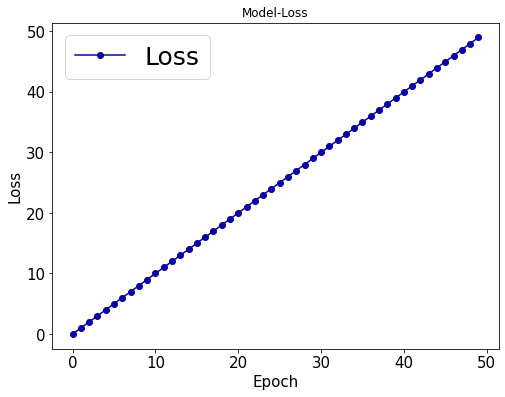

In [ ]:
import matplotlib.pyplot as plt

losses = list(range(0, 50))
# Create a list of indices (epochs)
epochs = list(range(0, len(losses)))
# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses , marker='o', color='#0802A3', label='Loss')
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
# Increase Xticks and Yticks Size
plt.xticks(fontsize=15)  # Set the fontsize for xticks
plt.yticks(fontsize=15)  # Set the fontsize for yticks

plt.title('Model-Loss')
# plt.grid(True)
plt.legend(fontsize=25)
plt.show()
# plt.savefig('results/model_loss.jpg')

In [ ]:
# Specify the path to the saved model checkpoint
model_checkpoint_path = 'best_model.pth'

In [ ]:
# Load the saved model state_dict
model.load_state_dict(torch.load(model_checkpoint_path))

<All keys matched successfully>

validation

In [ ]:

import csv

def SaveResults(Batch, Epoch, LR, MSE, RMSE):
    # Specify the CSV file path
    csv_file_path = 'results/results.csv'

    # Write data to CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        # Define the header names
        fieldnames = ['Batch', 'Epoch', 'LR', 'MSE', 'RMSE']
        
        # Create a CSV writer object with specified fieldnames
        csvwriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Check if the file is empty, if so, write the header row
        if csvfile.tell() == 0:
            csvwriter.writeheader()
            
        # Write the data row
        csvwriter.writerow({'Batch': batch_size, 'Epoch': num_epochs, 'LR': lr, 'MSE': MSE, 'RMSE': RMSE})


In [ ]:
outputss = []
targetss = []

if cr == 0:
    # Define the model, loss function, and optimizer
    criterion = nn.MSELoss()
else:
    # create a function (this my favorite choice)
    def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))
    criterion = RMSELoss

# Evaluate the model on the validation data
with torch.no_grad():
    total_loss = 0
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputss.append(outputs[:,0].tolist())
        targetss.append(targets.tolist())
        loss = criterion(outputs[:,0], targets.float())
        total_loss += loss.item()
    mean_loss = total_loss / len(val_loader)
    if cr == 0:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(batch_size, num_epochs, lr, mean_loss, lowest_loss)
    else:
        print("Batch Size %d , Epochs %d , Learning Rate %f , Loss %f"%(batch_size, num_epochs, lr, lowest_loss))
        print(f'MSE Loss: {mean_loss:.4f}')
        SaveResults(batch_size, num_epochs, lr,lowest_loss, mean_loss)

Batch Size 30 , Epochs 50 , Learning Rate 0.001000 , Loss 100000.000000
MSE Loss: 14.7337


Flatten the data

In [ ]:
outputs = []
for i in outputss:
    for j in i:
        outputs.append(j)

targets = []
for i in targetss:
    for j in i:
        targets.append(j)

In [ ]:
import matplotlib.pyplot as plt
import torch


t_len =int(len(targets)/12) 
o_len = int(len(outputs)/12)
# Extract the values from the tensors
# Create a list of index positions (x-values)
indices_t = list(range(t_len))  
indices_o = list(range(o_len))

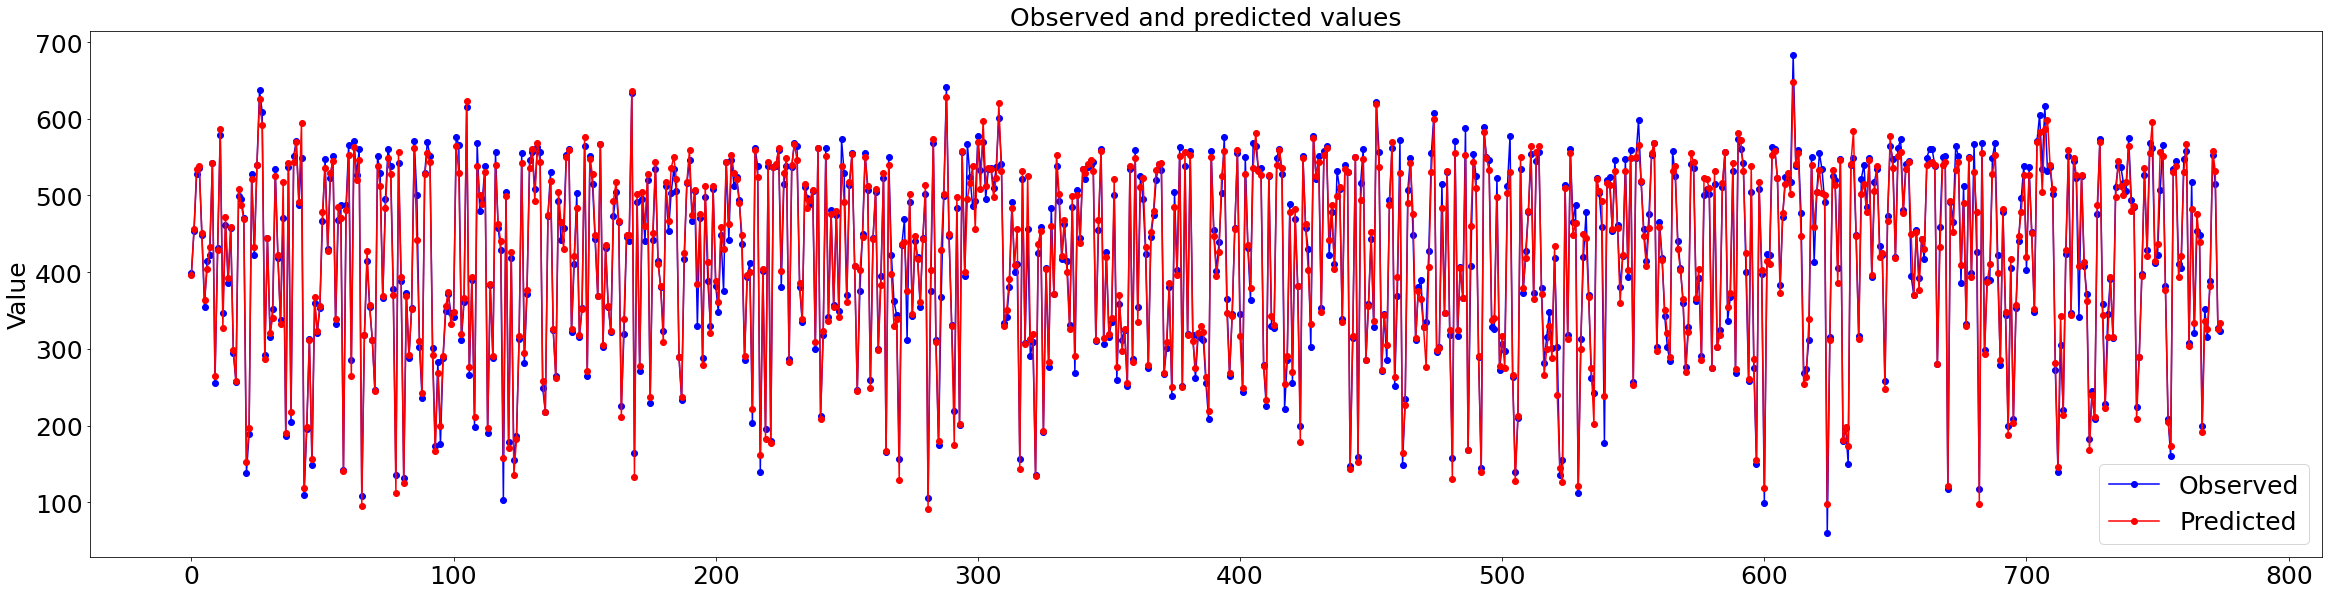

In [ ]:
import matplotlib.pyplot as plt

# Your existing code...

# Create a plot
plt.figure(figsize=(40, 10))  # Adjust the figure size as needed

# Plot the values against their index positions
plt.plot(indices_t, targets[0:t_len], marker='o', linestyle='-', color='blue')
plt.plot(indices_o, outputs[0:o_len], marker='o', linestyle='-', color='red')

# Add labels and a title
plt.ylabel('Value', fontsize=25)  # Adjust fontsize for ylabel
plt.title('Observed and predicted values', fontsize=25)  # Adjust fontsize for title

# Increase Legend Size
plt.legend(labels=['Observed', 'Predicted'], fontsize=25)
plt.subplots_adjust(bottom=0.15)
# Increase Xticks and Yticks Size
plt.xticks(fontsize=25)  # Set the fontsize for xticks
plt.yticks(fontsize=25)  # Set the fontsize for yticks

# Save and display the plot
plt.savefig('results/performance.png')
plt.show()


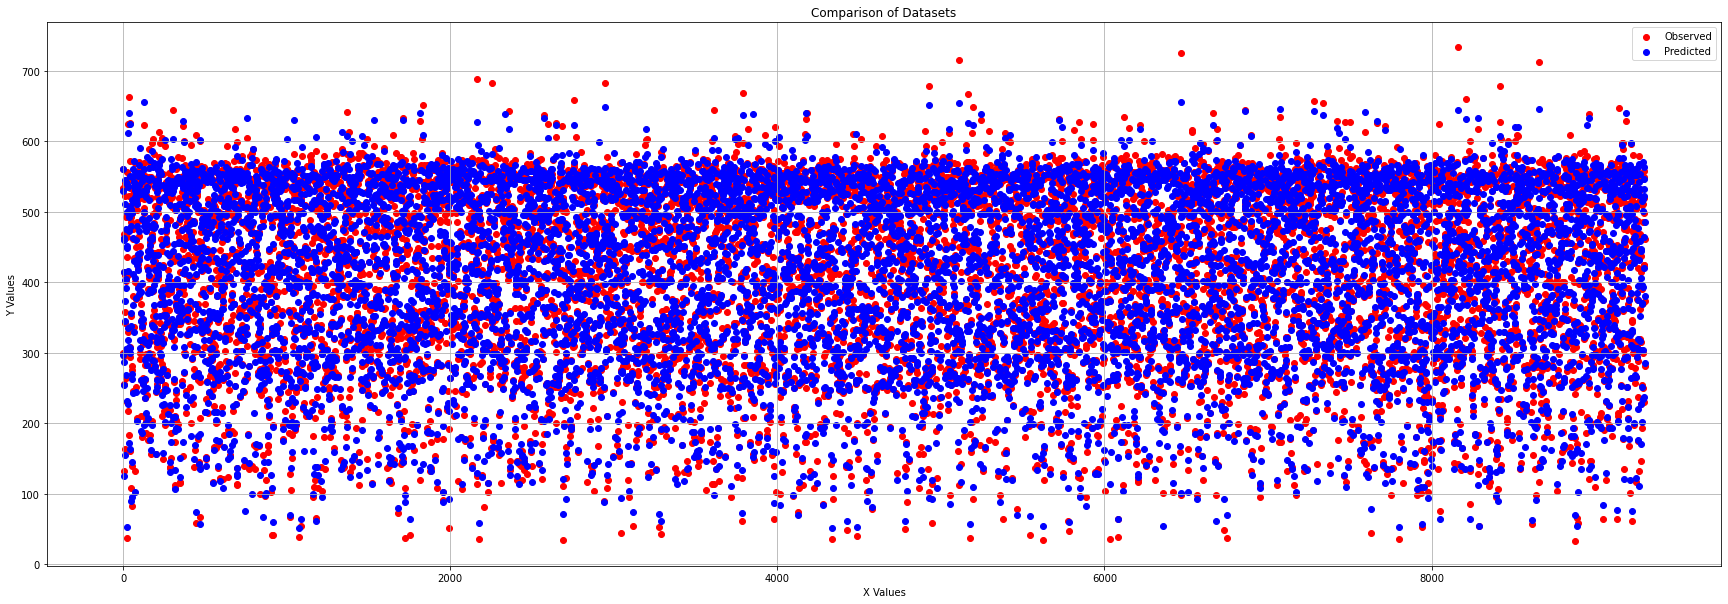

In [ ]:
# Create a scatter plot for both datasets
plt.figure(figsize=(30, 10))  # Adjust the figure size as needed
plt.scatter(indices_t, targets, color='red', label='Observed', marker='o')  # Red dots for dataset 1
plt.scatter(indices_o, outputs, color='blue', label='Predicted', marker='o')  # Blue dots for dataset 2

plt.title('Comparison of Datasets')  # Set the plot title
plt.xlabel('X Values')  # Set the x-axis label
plt.ylabel('Y Values')  # Set the y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Add a grid (optional)
plt.show()  # Display the plot


In [ ]:
# import os
# os.system("shutdown /s /t 1")

dataset preparation

In [ ]:
# import pandas as pd
# import os

# def get_ds(path, labels):
#     pyranometer = pd.read_csv(labels)
#     images = os.listdir(path)

#     #convert column 1 to int
#     pyranometer.iloc[:,0] = pyranometer.iloc[:,0].astype(int)

#     #convert to image names
#     pyranometer.iloc[:,0] = pyranometer.iloc[:,0].apply(lambda x: str(x) + 'IR.png')

#     # Filter pyranometer DataFrame based on the 'x' column

#     filtered_pyranometer = pyranometer[pyranometer.iloc[:,0].isin(images)]

#     # # Display the result
#     # filtered_pyranometer.to_csv('2017_12_08/pyranometer/filtered_pyranometer_ir.csv', index=False)
                
#     filtered_pyranometer.columns = ['name', 'value']

#     filtered_pyranometer = filtered_pyranometer.drop_duplicates(subset='name')
#     return filtered_pyranometer

In [ ]:
# # import datetime module
# import datetime
# import shutil
# from tqdm import tqdm

# # consider the start date as 2021-....
# start_date = datetime.date(2017, 12, 8)
 
# # consider the end date as 2021-.....
# end_date = datetime.date(2017, 12, 10)
 
# # delta time
# delta = datetime.timedelta(days=1)
 
# # Initialize an empty DataFrame to store the results
# ds = pd.DataFrame()

# def copy(src, dst):
#     if os.path.isdir(dst):
#         dst = os.path.join(dst, os.path.basename(src))
#     shutil.copyfile(src, dst)

# # iterate over range of dates
# while tqdm((start_date <= end_date)):
#     try:
#         date = start_date.strftime('%Y_%m_%d')
#         print(date, end="\n")
#         path = f'images/{date}/infrared'
#         labels = f'images/{date}/pyranometer/{date}.csv'
#         ds_temp = get_ds(path, labels)
#         ds = ds.append(ds_temp)
#         destination_path = 'mini_ds/'
#         img_lst = os.listdir(path=path)
#         for img in tqdm(img_lst):
#             shutil.copy(os.path.join(path,img), destination_path)
#     except: 
#         start_date += delta
#         continue
#     start_date += delta
# # Save the combined DataFrame to a CSV file
# ds.to_csv('mini_ds.csv', index=False)

In [ ]:
# # import datetime module
# import datetime
# import shutil
# import zipfile

# # consider the start date as 2021-february 1 st
# start_date = datetime.date(2017, 12, 8)
 
# # consider the end date as 2021-march 1 st
# end_date = datetime.date(2018, 1, 7)
 
# # delta time
# delta = datetime.timedelta(days=1)
 
# # iterate over range of dates
# while (start_date <= end_date):
#     date = start_date.strftime('%Y_%m_%d')
#     zip_file_path = f'dataset/{date}.zip'
#     extraction_path = 'images/'
#     try:
#         with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#             # Extract all the contents of the ZIP file to the specified directory
#             zip_ref.extractall(extraction_path)
#     except: 
#         start_date += delta
#         continue
    
#     print(date, end="\n")
#     start_date += delta